In [45]:
import filterpy.kalman as kf
from filterpy.common import Q_discrete_white_noise
from target import Target
import numpy as np
import matplotlib.pyplot as plt
random_seed = 0

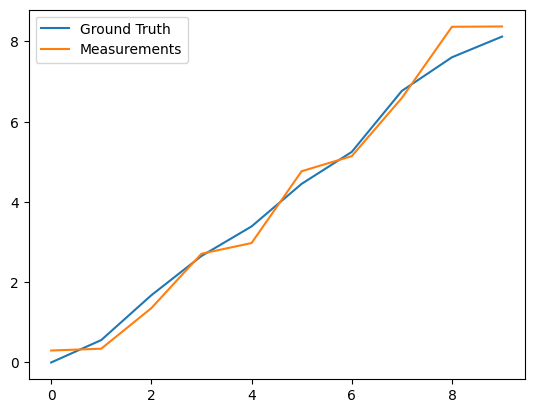

In [46]:
# Testing the target class
test_target = Target(initial_position=0, velocity=1, process_variance=0.1, measurement_variance=0.1, seed=random_seed)

ground_truth = []
measurements = []
for x in range(10):
    ground_truth.append(test_target.get_position())
    measurements.append(test_target.get_measurement())
    test_target.update(time_step=1)

plt.plot(ground_truth, label='Ground Truth')
plt.plot(measurements, label='Measurements')
plt.legend()
plt.show()

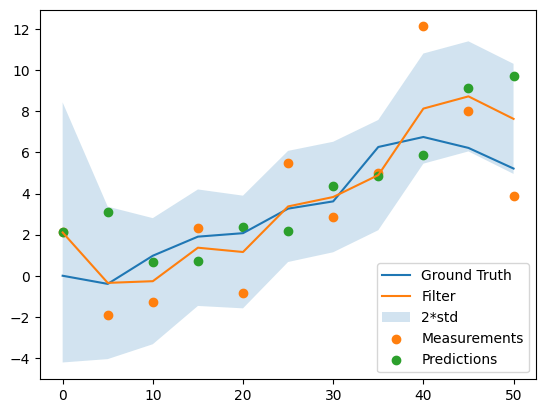

In [47]:
# R is the measurement noise/variance
R = 5
# Q is the process noise/variance
Q = 1
# P is the variance of the system
init_P = 10
P = init_P
# z is the measurement

# Set time span
samples = 11
time = np.linspace(0, 50, samples)

# Create a target to track
t1 = Target(initial_position=0, velocity=1, process_variance=Q, measurement_variance=R, seed=random_seed)

ground_truth = np.zeros_like(time)
measurements = np.zeros_like(time)
predictions = np.zeros_like(time)
filter = np.zeros_like(time)
variance = np.zeros_like(time)

# Get an initial state from measurementing the target
x = t1.get_measurement()
ground_truth[0] = t1.get_position()
measurements[0] = x
predictions[0] = x
filter[0] = x
variance[0] = P

# Now we loop through and update the target
for i in range(1, samples):
    t1.update(time_step=1)
    # Predict the next state
    x, P = kf.predict(x=x, P=P, u=1., Q=Q)
    predictions[i] = x

    # Get the measurement
    z = t1.get_measurement()

    # Update the target with the new measurement
    x, P = kf.update(x=x, P=P, z=z, R=R)

    measurements[i] = z
    ground_truth[i] = t1.get_position()
    filter[i] = x
    variance[i] = P

std = np.sqrt(variance)
plt.plot(time, ground_truth, label='Ground Truth')
plt.plot(time, filter, label='Filter')
plt.fill_between(time, filter+std*2, filter-std*2, alpha=0.2, label='2*std')
plt.scatter(time, measurements, label='Measurements')
plt.scatter(time, predictions, label='Predictions')
plt.legend()
plt.show()

In [48]:
# Creates a helper function to combine two beliefs
def product(x1, x2, P1, P2):
    x = (P2*x1 + P1*x2) / (P1 + P2)
    P = 1 / (1/P1 + 1/P2)
    return x, P

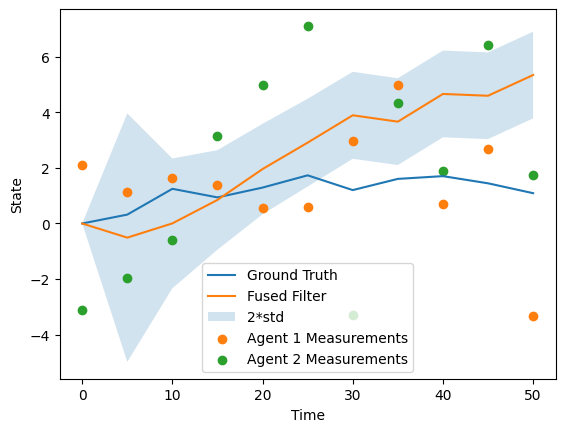

In [49]:
### Now we test this with two agents sampling the same target

# Note that we use the same R, Q, P values and target parameters, though separate P for each filter's belief
P_1 = init_P
P_2 = init_P

# Set time span
samples = 11
time = np.linspace(0, 50, samples)

# Create a target to track
t2 = Target(initial_position=0, velocity=1, process_variance=Q, measurement_variance=R, seed=random_seed)

ground_truth = np.zeros_like(time)
m1 = np.zeros_like(time)
p1 = np.zeros_like(time)
f1 = np.zeros_like(time)
v1 = np.zeros_like(time)
m2 = np.zeros_like(time)
p2 = np.zeros_like(time)
f2 = np.zeros_like(time)
v2 = np.zeros_like(time)
fused_state = np.zeros_like(time)
fused_variance = np.zeros_like(time)

# Get an initial state from measurementing the target
x_1 = t2.get_measurement()
x_2 = t2.get_measurement()
ground_truth[0] = t2.get_position()
m1[0] = x_1
p1[0] = x_1
f1[0] = x_1
v1[0] = P_1
m2[0] = x_2
p2[0] = x_2
f2[0] = x_2
v2[0] = P_2

# Now we loop through and update the target
for i in range(1, samples):
    t2.update(time_step=1)

    # Each the agents then naively combines their beliefs
    x_1, P_1 = product(x_1, x_2, P_1, P_2)
    x_2, P_2 = x_1, P_1
    fused_state[i] = x_1
    fused_variance[i] = P_1


    # Predict the next state
    x_1, P_1 = kf.predict(x=x_1, P=P_1, u=1., Q=Q)
    p1[i] = x_1
    x_2, P_2 = kf.predict(x=x_2, P=P_2, u=1., Q=Q)
    p2[i] = x_2

    # Get the measurement
    z_1 = t2.get_measurement()
    z_2 = t2.get_measurement()

    # Update the target with the new measurement
    x_1, P_1 = kf.update(x=x_1, P=P_1, z=z_1, R=R)
    x_2, P_2 = kf.update(x=x_2, P=P_2, z=z_2, R=R)

    ground_truth[i] = t2.get_position()
    m1[i] = z_1
    f1[i] = x_1
    v1[i] = P_1
    m2[i] = z_2
    f2[i] = x_2
    v2[i] = P_2

std1 = np.sqrt(v1)
std2 = np.sqrt(v2)
fused_std = np.sqrt(fused_variance)
plt.plot(time, ground_truth, label='Ground Truth')
plt.plot(time, fused_state, label='Fused Filter')
plt.fill_between(time, fused_state+fused_std*2, fused_state-fused_std*2, alpha=0.2, label='2*std')
plt.scatter(time, m1, label='Agent 1 Measurements')
plt.scatter(time, m2, label='Agent 2 Measurements')
plt.xlabel('Time')
plt.ylabel('State')
#plt.scatter(time, p1, label='Predictions')
plt.legend()
plt.show()